- This notebook consists of step by step training, evaluation, and saving the trained models as well as the prediction arrays. 
- The model reconstructions are visualised here, for 3D AE model with 2 strategies of temporal encodings.
- This is an extra notebook that is created for step by step process. The temporal_ae_executions is the main notebook for running the models over 3 executions, averaging the results, and saving in JSONs. 

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')
# sys.path.append('/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/GITHUB/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [3]:
import pickle
import time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Dataset prep: B10 with Date Encodings as Additional Channels

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10 + 2, 64, 64)

2 extra channels for temporal encoding of sin(date_diff) and cos(date_diff)

In [4]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'b10_channel', method='sin-cos')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'b10_channel', method='sin-cos')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([1228, 7, 12, 64, 64]), torch.Size([48, 7, 12, 64, 64]))

Dictionary for subpatch-to-patch mapping of reconstructed images

In [5]:
old_images_train = {fn: img for fn, img in zip(field_numbers_train, images_visualisation_train)}
old_images_eval = {fn: img for fn, img in zip(field_numbers_eval, images_visualisation_eval)}

In [6]:
acq_dict_train = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_train)}
acq_dict_eval = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_eval)}

### Create Sub-Patches

In [7]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size, num_encoding_channels=config.num_encoding_channels)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size, num_encoding_channels=config.num_encoding_channels)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([33128, 7, 12, 4, 4]), torch.Size([1197, 7, 12, 4, 4]))

Get field numbers and co-ordinates as string

In [8]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
train_coord_dataloader[0]

'1167136.0_1167138.0_24_24'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [9]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_dataloader, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

## Modeling: Conv3D Autoencoder with Temporal Encodings as channels

### Architecture

Input Data: ( N x C x D x H x W )

In [21]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, out_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, out_channels, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

### Training

In [22]:
device = 'cuda'
epochs = 50
lr = 0.001
momentum = 0.9
latent_dim = 32
in_channels = 12
out_channels = 10
time_steps = 7
optimizer = 'Adam'
patch_size = config.subpatch_size

model = Conv3DAutoencoder(in_channels, out_channels, time_steps, latent_dim, patch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(12, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28672, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=28672, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 7, 4, 4))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv3): ConvTranspose3d(64, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

##### Note: To skip training, skip the next cell and go to evalaution section (just after the loss curves), and uncomment and run the cells for loading the saved models.

In [23]:
trained_model, train_losses, test_losses = train_model_ae_te(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

Time taken per epoch: 6.8852 seconds
Epoch 1/50, Train Loss: 0.002243, Test Loss: 0.000690
Time taken per epoch: 6.8231 seconds
Epoch 2/50, Train Loss: 0.000564, Test Loss: 0.000613
Time taken per epoch: 6.9161 seconds
Epoch 3/50, Train Loss: 0.000315, Test Loss: 0.000291
Time taken per epoch: 6.8777 seconds
Epoch 4/50, Train Loss: 0.000244, Test Loss: 0.000208
Time taken per epoch: 6.9096 seconds
Epoch 5/50, Train Loss: 0.000214, Test Loss: 0.000202
Time taken per epoch: 6.8670 seconds
Epoch 6/50, Train Loss: 0.000202, Test Loss: 0.000244
Time taken per epoch: 6.8746 seconds
Epoch 7/50, Train Loss: 0.000191, Test Loss: 0.000207
Time taken per epoch: 6.8132 seconds
Epoch 8/50, Train Loss: 0.000183, Test Loss: 0.000191
Time taken per epoch: 6.8194 seconds
Epoch 9/50, Train Loss: 0.000164, Test Loss: 0.000160
Time taken per epoch: 6.8783 seconds
Epoch 10/50, Train Loss: 0.000161, Test Loss: 0.000152
Time taken per epoch: 6.9038 seconds
Epoch 11/50, Train Loss: 0.000150, Test Loss: 0.0001

### Evaluation

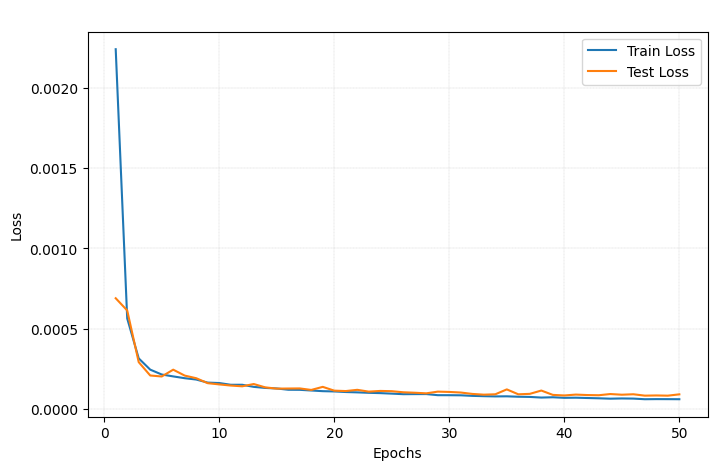

In [24]:
plot_loss(train_losses, test_losses, title=" ")

##### NOTE: Load Saved Model to skip Training the model

Load Saved Model to skip Training

In [25]:
# with open(config.kmeans_ae_3D_TE_path, 'rb') as file:
#     kmeans = pickle.load(file)

In [26]:
# trained_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)

# with open(config.ae_3d_TE_path, 'rb') as file:
#     trained_model = pickle.load(file)

##### Metrics

Use trained Encoder part to get the features for train, test and evaluation Data

In [27]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, temp_embed_pixel=False, device=device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, temp_embed_pixel=False, device=device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, temp_embed_pixel=False, device=device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [28]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=26)   #skip when using saved model

In [29]:
train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Clustering Accuracy

In [30]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 1
Accuracy: 73.77
Precision: 74.36
Recall: 82.86
F1-score: 78.38
F2-score: 81.01


Save Models

In [31]:
# with open(config.ae_3d_TE_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [32]:
# with open(config.kmeans_ae_3D_TE_path, 'wb') as file:
#     pickle.dump(kmeans, file)

### Visualisations

Visualise Sub-patch-level Reconstructions => Random Image

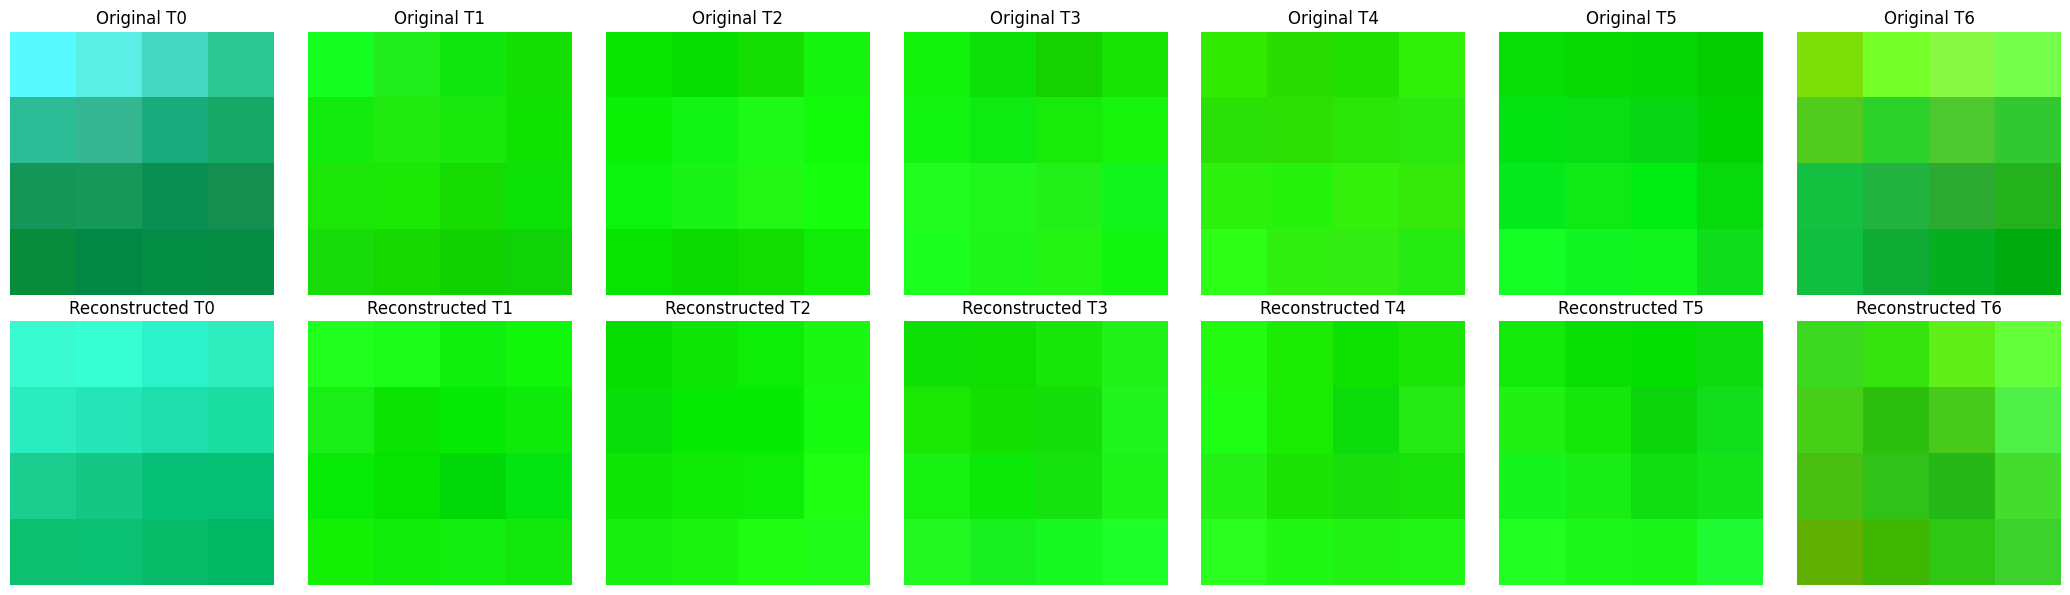

In [41]:
plot_reconstructed_subpatches_temporal(trained_model, dataloader_train, 1, device)

Map subpatch-level to patches and Visualise Patch level reconstructions => Random Image

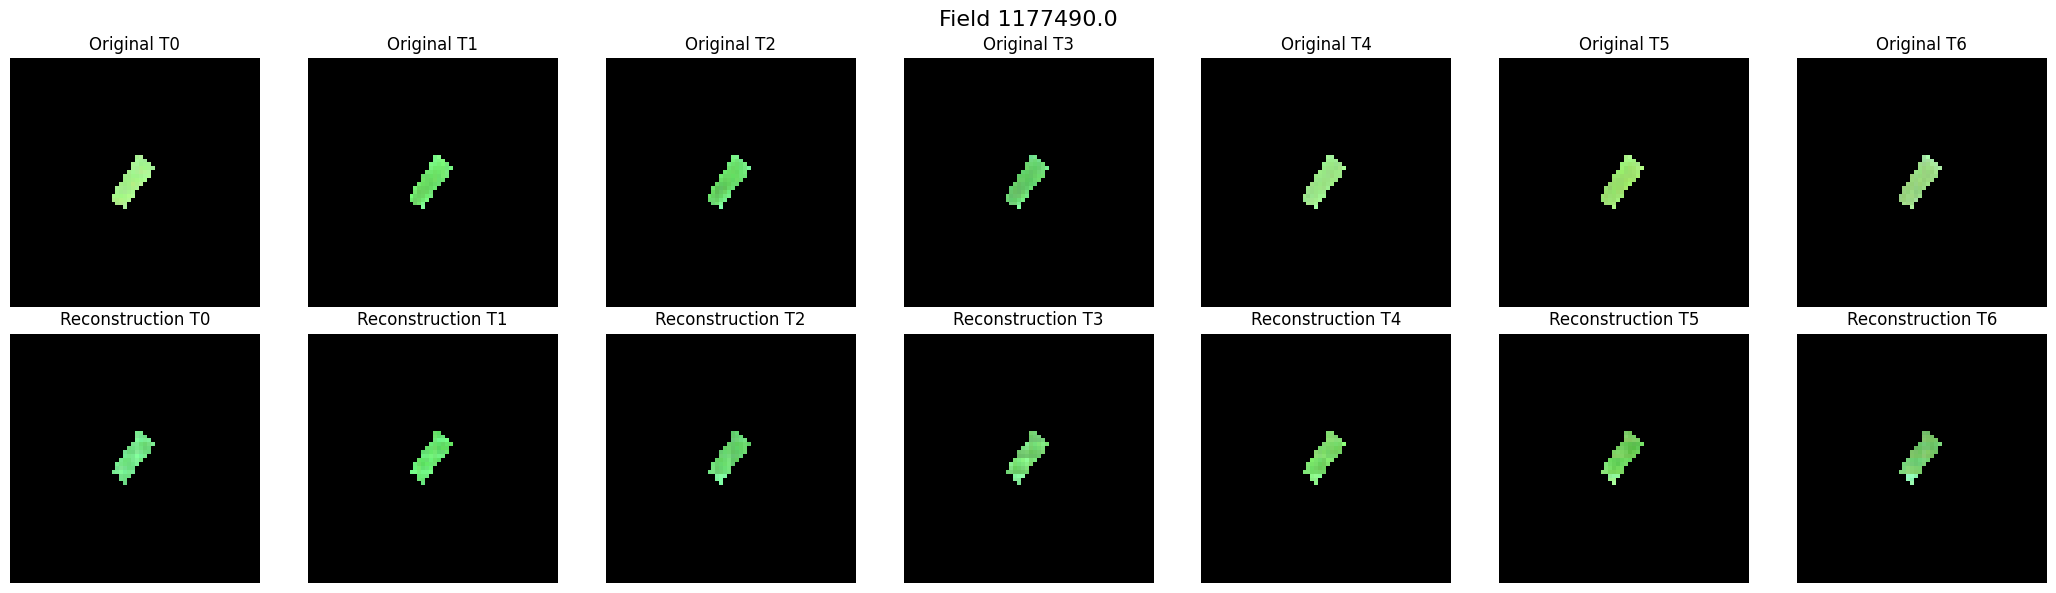

In [69]:
plot_reconstructed_patches_temporal(trained_model, dataloader_eval, old_images_eval, 1, device)

## Dataset prep: B10 with Temporal Encodings as addition

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [4]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, date_emb_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'b10_add', method='sin-cos')
field_numbers_eval, acquisition_dates_eval, date_emb_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'b10_add', method='sin-cos')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([1228, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

In [5]:
date_emb_train[0][0]   # [sin, cos]

[np.float64(0.2348860457809847), np.float64(-0.9720229140804105)]

Dictionary for subpatch-to-patch mapping of reconstructed images

In [6]:
old_images_train = {fn: img for fn, img in zip(field_numbers_train, images_visualisation_train)}
old_images_eval = {fn: img for fn, img in zip(field_numbers_eval, images_visualisation_eval)}

In [7]:
acq_dict_train = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_train)}
acq_dict_eval = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_eval)}

### Create Sub-Patches

In [8]:
train_subpatches, train_subpatch_coords, train_subpatch_date_emb = non_overlapping_sliding_window_with_date_emb(patch_tensor_train, field_numbers_train, date_emb_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords, eval_subpatch_date_emb = non_overlapping_sliding_window_with_date_emb(patch_tensor_eval, field_numbers_eval, date_emb_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([33128, 7, 10, 4, 4]), torch.Size([1197, 7, 10, 4, 4]))

Get field numbers and co-ordinates as string

In [9]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
eval_coord_dataloader[0], len(eval_coord_dataloader), len(train_coord_dataloader)

('1168039.0_20_24', 1197, 33128)

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders
The data loader function for MAE is used since it is designed to take temporal encodings additionally

In [10]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers, train_date_embeddings, test_date_embeddings = train_test_split(
    train_subpatches, train_coord_dataloader, train_subpatch_date_emb, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader_mae(train_subpatches_dl, train_field_numbers, train_date_embeddings, mae=False, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader_mae(test_subpatches, test_field_numbers, test_date_embeddings, mae=False, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader_mae(eval_subpatches, eval_coord_dataloader, eval_subpatch_date_emb, mae=False, batch_size=config.ae_batch_size, shuffle=False)

## Modeling: Conv3D Autoencoder with Pixel-level Date Encodings addition

### Architecture

Input Data: ( N x C x D x H x W )

In [11]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

        # --- Temporal embedding projection to match channels (needed for alignment) ---
        self.temb_proj = nn.Conv3d(2, in_channels, kernel_size=1)


    def forward(self, x, date_embeddings):

        # --- Date embedding processing ---
        # Convert the date embeddings to the shape (B, 2, 7, 4, 4)
        if not isinstance(date_embeddings, torch.Tensor):
            date_embeddings_tensor = torch.tensor(date_embeddings, dtype=torch.float32).to(x.device)    # Shape: (B, 7, 2)
        date_embeddings_tensor = date_embeddings_tensor.permute(0, 2, 1)                                # Shape: (B, 2, 7)
        date_embeddings_tensor = date_embeddings_tensor.unsqueeze(-1).unsqueeze(-1)                     # Shape: (B, 2, 7, 1, 1)
        date_embeddings_tensor = date_embeddings_tensor.expand(-1, -1, -1, x.shape[3], x.shape[4])      # Shape: (B, 2, 7, 4, 4)

        # Project the date embeddings to match the channels
        date_embeddings_tensor = self.temb_proj(date_embeddings_tensor)                                 # Shape: (B, 10, 7, 4, 4)
        # print('x shape before time embedding:',x.shape)
        # print('time embeddings:',date_embeddings_tensor.shape)
        
        # --- Add date embeddings to the input tensor ---
        x = x + date_embeddings_tensor                                                                  # Shape: (B, 10, 7, 4, 4)
        # print('x shape after time embedding',x.shape)
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

### Training

In [12]:
device = 'cuda'
epochs = 50
lr = 0.001
momentum = 0.9
latent_dim = 32
channels = 10
time_steps = 7
optimizer = 'Adam'
patch_size = config.subpatch_size

model = Conv3DAutoencoder(channels, time_steps, latent_dim, patch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28672, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=28672, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 7, 4, 4))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv3): ConvTranspose3d(64, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (temb_proj): Conv3d(2, 10, kernel_size=(1, 1, 1), stride=(1, 1,

##### Note: To skip training, skip the next cell and go to evalaution section (just after the loss curves), and uncomment and run the cells for loading the saved models.

In [164]:
trained_model, train_losses, test_losses = train_model_ae_te_pixel(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

Time taken per epoch: 6.9149 seconds
Epoch 1/50, Train Loss: 0.004377, Test Loss: 0.000746
Time taken per epoch: 6.8594 seconds
Epoch 2/50, Train Loss: 0.000582, Test Loss: 0.000402
Time taken per epoch: 6.8841 seconds
Epoch 3/50, Train Loss: 0.000330, Test Loss: 0.000444
Time taken per epoch: 6.8778 seconds
Epoch 4/50, Train Loss: 0.000249, Test Loss: 0.000235
Time taken per epoch: 6.8847 seconds
Epoch 5/50, Train Loss: 0.000228, Test Loss: 0.000216
Time taken per epoch: 6.9891 seconds
Epoch 6/50, Train Loss: 0.000210, Test Loss: 0.000219
Time taken per epoch: 6.9550 seconds
Epoch 7/50, Train Loss: 0.000196, Test Loss: 0.000233
Time taken per epoch: 6.9170 seconds
Epoch 8/50, Train Loss: 0.000181, Test Loss: 0.000179
Time taken per epoch: 6.8755 seconds
Epoch 9/50, Train Loss: 0.000167, Test Loss: 0.000163
Time taken per epoch: 6.8959 seconds
Epoch 10/50, Train Loss: 0.000162, Test Loss: 0.000235
Time taken per epoch: 6.8722 seconds
Epoch 11/50, Train Loss: 0.000156, Test Loss: 0.0002

### Evaluation

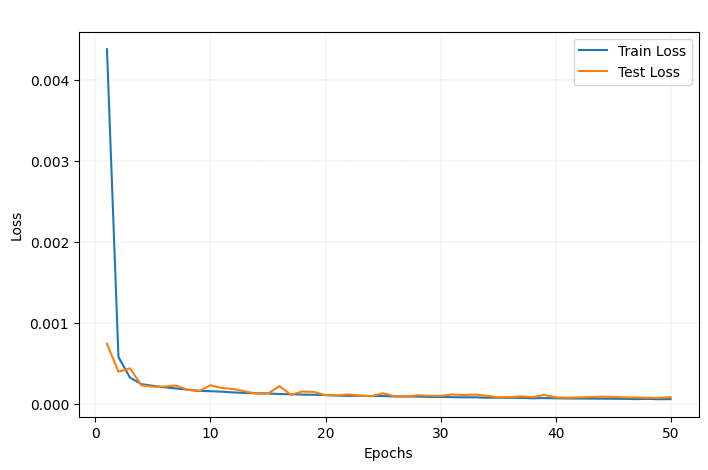

In [165]:
plot_loss(train_losses, test_losses, title=" ")

##### NOTE: Load Saved Model to skip Training the model

Load Saved Model to skip Training

In [14]:
# with open(config.kmeans_ae_3D_TEadd_path, 'rb') as file:
#     kmeans = pickle.load(file)

/home/k64835/Master-Thesis-SITS/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [18]:
# device = 'cuda'
# latent_dim = 32
# channels = 10
# time_steps = 7
# trained_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)

# with open(config.ae_3d_TEadd_path, 'rb') as file:
#     trained_model = pickle.load(file)

# trained_model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28672, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=28672, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 7, 4, 4))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv3): ConvTranspose3d(64, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (temb_proj): Conv3d(2, 10, kernel_size=(1, 1, 1), stride=(1, 1,

##### Metrics

Use trained Encoder part to get the features for train, test and evaluation Data

In [19]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, temp_embed_pixel=True, device=device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, temp_embed_pixel=True, device=device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, temp_embed_pixel=True, device=device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [169]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=29)  # skip when loading saved models

In [20]:
train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

In [21]:
unique, counts = np.unique(eval_subpatch_predictions, return_counts=True)
print(dict(zip(unique, counts)))

{np.int32(0): np.int64(375), np.int32(1): np.int64(822)}


Clustering Accuracy

In [22]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold, '3D_AE', True)  #for saving predictions
# disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 1
Accuracy: 67.21
Precision: 67.44
Recall: 82.86
F1-score: 74.36
F2-score: 79.23


Assign field labels to training data for creating final visualisation images

In [ ]:
train_field_labels = assign_field_labels_ae_train(combined_train_coords, train_subpatch_predictions, disease, config.subpatch_to_patch_threshold) #for box drawing

Save Models

In [173]:
# with open(config.ae_3d_TEadd_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [174]:
# with open(config.kmeans_ae_3D_TEadd_path, 'wb') as file:
#     pickle.dump(kmeans, file)

### Visualisations

Visualise Sub-patch-level Reconstructions => Random Image

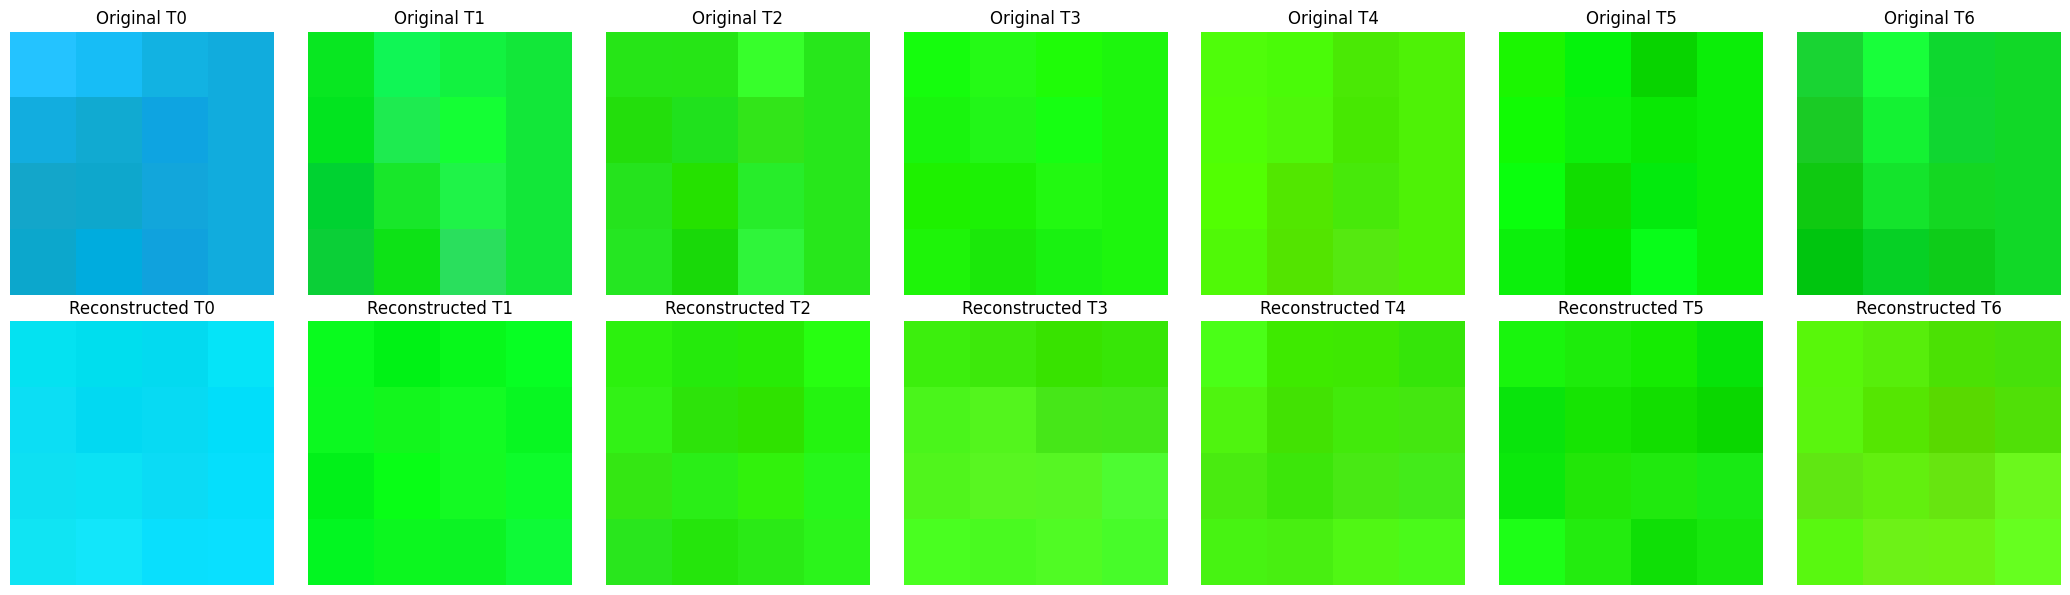

In [33]:
plot_reconstructed_subpatches_temporal(trained_model, dataloader_eval, 1, device, model_type='ae_te')

Map subpatch-level to patches and Visualise Patch level reconstructions => Random Image

/tmp/ipykernel_277975/2135193741.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  date_embeddings_tensor = torch.tensor(date_embeddings, dtype=torch.float32).to(x.device)    # Shape: (B, 7, 2)


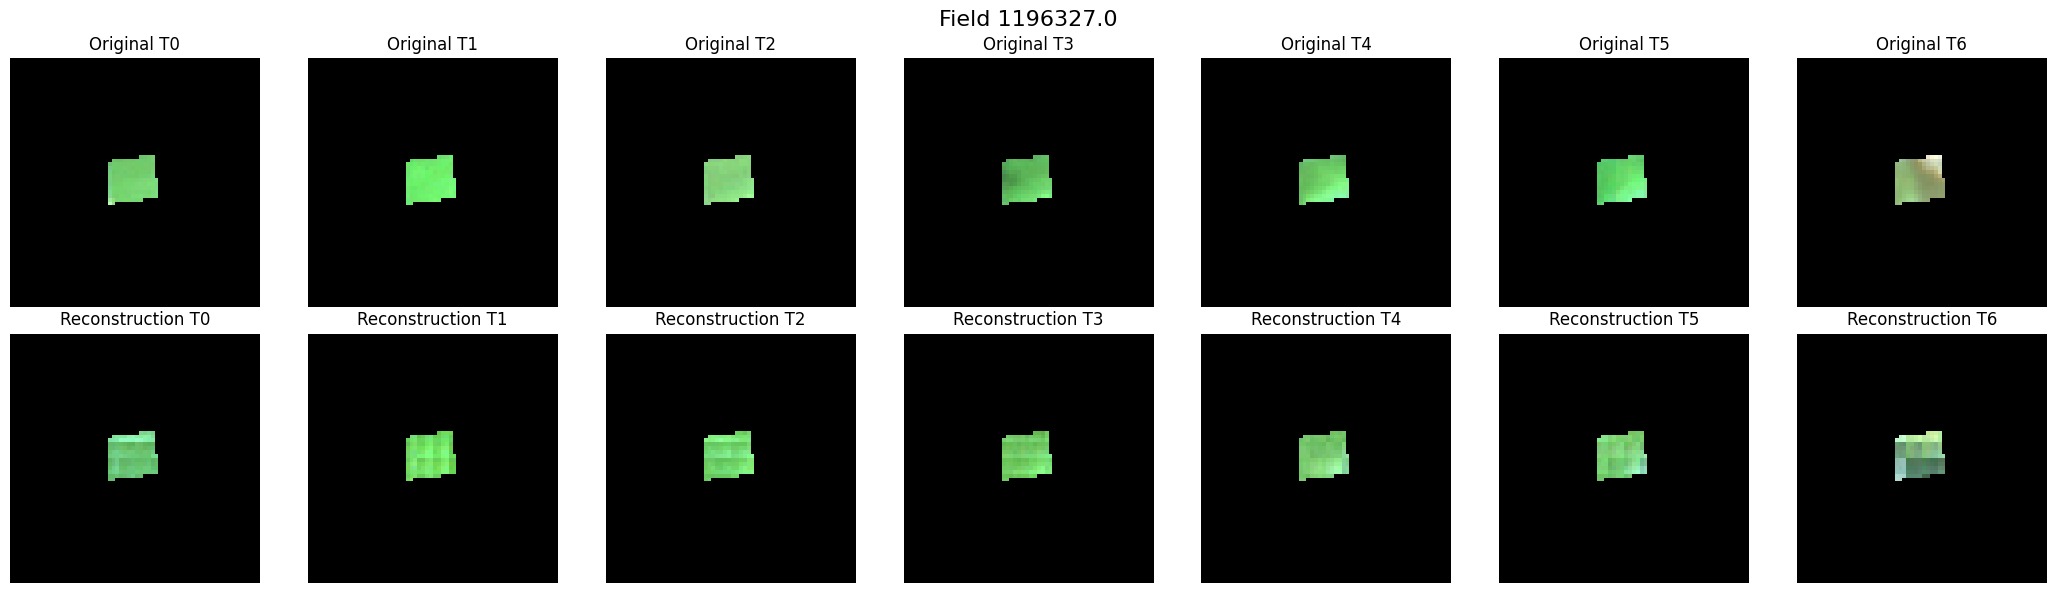

In [47]:
plot_reconstructed_patches_temporal(trained_model, dataloader_eval, old_images_eval, 1, device, model_type='ae_te')